In [19]:
import boto3 #Amazon AWS Python SDK
from botocore.config import Config #Config for SDK
from dotenv import load_dotenv # Load .ENV file containing protected information
import os # Ability to manage and access neigboring files 
from io import BytesIO
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Make the environment variables available to python from the .env file
load_dotenv()
# Load the environment variables into python variables
ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

In [3]:
# Initialize a session using the AWS keys
session = boto3.Session( # Session object used to configure users and environment control
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
)

In [4]:
# Create a client with session and speficy the endpoint (where the data is located)
s3 = session.client(
    's3', # Connecting to the S3 (Simple Storage Service) specifically (can connect to any aws service here)
    endpoint_url='https://files.polygon.io', # Base url for the service you want to access
    config=Config(signature_version='s3v4'), # Ensures client is using AWS signature Version 4 protocol by prohibiting api requests unless supplied with
                                             # a secret key. Used for hashsing
)
# The previous code is everything needed to accesss the S3 flatfiles, from here you can use commands like list objects or get objects

In [5]:
# Initialize a paginator for listing objects
paginator = s3.get_paginator('list_objects_v2')

In [6]:
# Choose the appropriate prefix depending on the data you need:
# - 'global_crypto' for global cryptocurrency data
# - 'global_forex' for global forex data
# - 'us_indices' for US indices data
# - 'us_options_opra' for US options (OPRA) data
# - 'us_stocks_sip' for US stocks (SIP) data
def get_daily_polygon_files(start_year, years):
    """
    returns all the s3 files to download

    Args:
        start_year (int): Year to start historical data pull.
        years (int): Amount of years to pull files for.

    Returns:
        object_keys: A list of files that will be pulled from S3.
    """
    #One liner to make the list of years to pull from. Paginator will recursively get all the files from s3
    prefixes = [f'us_stocks_sip/day_aggs_v1/{year}' for year in range(start_year, start_year + years)]
    # List objects using the selected prefix
    object_keys = []
    for prefix in prefixes:
        for page in paginator.paginate(Bucket='flatfiles', Prefix=prefix):
            for obj in page['Contents']:
                object_keys.append(obj['Key'])
    return object_keys

In [7]:
def get_daily_data(keys):
    """
    grabs all the csv files stored in keys, unzips them, and concatenates them all in a dataframe


    Args:
        keys (String[]): list of csv file paths to download from s3

    Returns:
        Dataframe: dataframe with stock data appended from all days
    """
    dfs = []
    for key in tqdm(keys, desc="Fetching Stock data"):
        if key.endswith('csv.gz'):
            response = s3.get_object(Bucket='flatfiles', Key=key)
            df = pd.read_csv(BytesIO(response['Body'].read()), compression = 'gzip')
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)            

In [8]:
data = get_daily_data(get_daily_polygon_files(2021, 5))

Fetching Stock data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1069/1069 [01:30<00:00, 11.82it/s]


In [9]:
def data_evaluation(data):
    """
    evaluates the data and prints null values and missing data

    Args:
        data: input data frame

    Returns:
        Void
    """
    ticker_counts = data['ticker'].value_counts()
    most_common_value = ticker_counts.mode().iloc[0]
    num_incomplete_tickers = int((ticker_counts != most_common_value).sum())
    incomplete_percentage = (num_incomplete_tickers / ticker_counts.size) * 100
    
    print(f"""
Amount of null values per column: \n {data.isnull().sum()} \n
Number of unique tickers: {data['ticker'].nunique()}
The mode of the amount of tickers is {most_common_value}
The number of incomplete tickers is {num_incomplete_tickers}
The percentage of incomplete tickers relative to the mode is {incomplete_percentage:.3f}%
    """)

In [10]:
data_evaluation(data)


Amount of null values per column: 
 ticker          684
volume            0
open              0
close             0
high              0
low               0
window_start      0
transactions      0
dtype: int64 

Number of unique tickers: 17970
The mode of the amount of tickers is 1069
The number of incomplete tickers is 12418
The percentage of incomplete tickers relative to the mode is 69.104%
    


In [11]:
#import numpy as np
#Example inject null values for testing
#data.loc[0, 'volume'] = np.nan

In [17]:
def get_clean_tickers(data):
    
    #Remove null tickers from ticker list
    unique_tickers = data['ticker'].dropna().unique()
    tickers_with_null = data[data.isnull().any(axis=1)]['ticker'].dropna().unique().tolist()
    valid_tickers = list(set(unique_tickers) - set(tickers_with_null))

    #Create new filtered DataFrame and filter further based on mode amount of samples
    filtered_null_data = data[data['ticker'].isin(valid_tickers)]
    ticker_counts = filtered_null_data['ticker'].value_counts()
    most_common_value = ticker_counts.mode().iloc[0]
    # Get tickers that don't have the mode number of rows
    incomplete_tickers = ticker_counts[ticker_counts != most_common_value].index.tolist()
    filtered_final_data = filtered_null_data[filtered_null_data['ticker'].isin(list(set(valid_tickers) - set(incomplete_tickers)))]

    #Print null tickers, evaulate final data, and return final df
    print(f"tickers with null: {tickers_with_null}")
    data_evaluation(filtered_final_data)
    filtered_final_data = filtered_final_data.copy()
    filtered_final_data['time'] = pd.to_datetime(filtered_final_data['window_start']).dt.date
    filtered_final_data.drop(columns=['window_start'])
    return filtered_final_data

In [18]:
filtered_data = get_clean_tickers(data)

tickers with null: []

Amount of null values per column: 
 ticker          0
volume          0
open            0
close           0
high            0
low             0
window_start    0
transactions    0
dtype: int64 

Number of unique tickers: 5552
The mode of the amount of tickers is 1069
The number of incomplete tickers is 0
The percentage of incomplete tickers relative to the mode is 0.000%
    


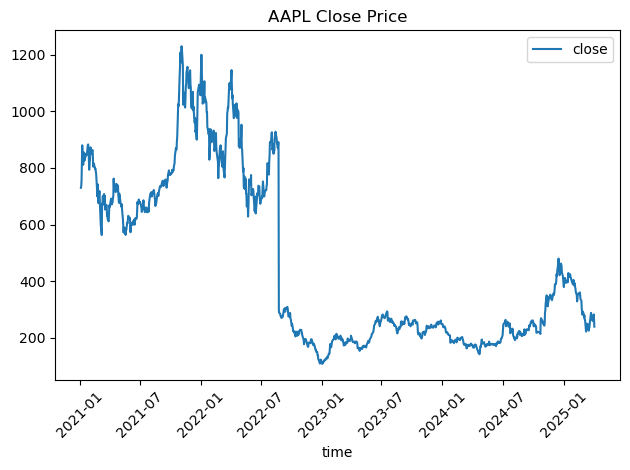

In [22]:
filtered_data[filtered_data['ticker'] == 'TSLA'].plot(x='time', y='close', title='AAPL Close Price')
plt.xticks(rotation=45)  # Rotate x-axis labels vertically
plt.tight_layout()       # Optional: prevent clipping
plt.show()

In [ ]:
def adjust_for_splits(data):
    